### Download german spacy pipeline

In [1]:
!python -m spacy download de_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 MB 6.1 MB/s eta 0:00:0000:0100:02
You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


In [2]:
!pip install fasttext

You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import spacy
import re
import umap
nlp = spacy.load('de_core_news_lg')

/Users/jannis/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv("/Users/jannis/ASUD_Cyberbullying/prepared_dataframe.csv")

In [5]:
df.head()

,tweet,binaereKlassifikation,granulareKlassifikation,Wörter in Tweet,Wörter pro Tweet,Tweets ohne Satzzeichen,Wortlänge,Durchschnittliche Wortlänge,Verlinkungen,Verlinkung pro Tweet,Hashtags,Hashtags pro Tweet,utf Codes,utf Codes pro Tweet,Emojis,Emojis pro Tweet
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,OFFENSE,INSULT,"['komisch', 'das', 'die', 'realitätsverweigeru...",11,"['Komisch', 'das', 'die', 'Realitätsverweigeru...","[7, 3, 3, 21, 5, 3, 6, 12, 9, 8, 7]",7.64,"['@JanZimmHHB', '@mopo']",2,[],0,[],0,[],0
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,OFFENSE,ABUSE,"['cdu', 'steht', 'seid', 'strauss,', 'kohl,', ...",13,"['CDU', 'steht', 'seid', 'Strauss', 'Kohl', 'S...","[3, 5, 4, 7, 4, 8, 7, 3, 10, 11, 3, 4, 7]",5.85,"['@faznet', '@Gruene_Europa', '@SPDEuropa', '@...",4,[],0,[],0,[],0
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",OTHER,OTHER,"['die', 'gesichter,', 'namen,', 'religion', 'd...",10,"['Die', 'Gesichter', 'Namen', 'Religion', 'der...","[3, 9, 5, 8, 3, 5, 5, 3, 10, 9]",6.00,['@DLFNachrichten'],1,[],0,[],0,[],0
3,@welt Wie verwirrt muss man sein um sich zu we...,OFFENSE,ABUSE,"['wie', 'verwirrt', 'muss', 'man', 'sein', 'um...",28,"['Wie', 'verwirrt', 'muss', 'man', 'sein', 'um...","[3, 8, 4, 3, 4, 2, 4, 2, 7, 3, 9, 12, 3, 6, 4,...",5.43,['@welt'],1,[],0,[],0,[],0
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,OFFENSE,ABUSE,"['weil', 'die', 'afd', 'den', 'ferkelfunk', 'a...",30,"['Weil', 'die', 'AfD', 'den', 'Ferkelfunk', 'a...","[4, 3, 3, 3, 10, 10, 4, 7, 5, 3, 6, 6, 11, 5, ...",5.17,"['@hacker_1991', '@torben_braga']",2,[],0,[],0,[],0


In [6]:
df.granulareKlassifikation.value_counts()

OTHER        2061
INSULT        459
ABUSE         400
PROFANITY     111
Name: granulareKlassifikation, dtype: int64

## Preprocess the tweets

In [7]:
# words in tweet as one string 
data = df 
data["tweets_clean"] = [" ".join(eval(word)) for word in data["Wörter in Tweet"]] 

# drop unicode emojis and LBR
new_tweet_ls = []
for tweet in data.tweets_clean:
    tweet_sp = tweet.split()
    for word in tweet_sp:
        if any(x in word for x in ["000", "LBR", "lbr"]) :
            tweet = tweet.replace(word, "")
        
    new_tweet_ls.append(tweet)

data["tweets_clean"] = new_tweet_ls

In [8]:
# preprocess the tweets
def process_tweets(tweet : str):
    # all lowercase
    tweet = tweet.lower()
    # remove Sonderzeichen etc (based on Sonderzeichen.txt)
    tweet = re.sub('[^a-zA-ZäöüÄÖÜß]', " ", tweet)
    return tweet

In [9]:
# split data in training and test
data_train = data.sample(round(0.75 * len(data)), random_state = 1).reset_index()
data_test = data[~data.index.isin(data_train.index)].reset_index()


In [10]:
data_pre = data_train
data_pre["tweets_clean"] = [process_tweets(tweet) for tweet in data_pre["tweet"]]

In [11]:
data_pre.head()

,index,tweet,binaereKlassifikation,granulareKlassifikation,Wörter in Tweet,Wörter pro Tweet,Tweets ohne Satzzeichen,Wortlänge,Durchschnittliche Wortlänge,Verlinkungen,Verlinkung pro Tweet,Hashtags,Hashtags pro Tweet,utf Codes,utf Codes pro Tweet,Emojis,Emojis pro Tweet,tweets_clean
0,6,@StZ_NEWS Aber bei läppischen 130.000 Euro der...,OTHER,OTHER,"['aber', 'bei', 'läppischen', '130.000', 'euro...",13,"['Aber', 'bei', 'läppischen', '130000', 'Euro'...","[4, 3, 10, 6, 4, 3, 3, 3, 4, 19, 6, 12, 3]",6.15,['@StZ_NEWS'],1,[],0,[],0,[],0,stz news aber bei läppischen euro der...
1,757,@EleFand @haiderbekah @Eisbert1887 Fand eklige...,OFFENSE,INSULT,"['fand', 'ekliger', 'body', 'shamer', 'schäm',...",6,"['Fand', 'ekliger', 'body', 'shamer', 'schäm',...","[4, 7, 4, 6, 5, 4]",5.00,"['@EleFand', '@haiderbekah', '@Eisbert1887']",3,[],0,[],0,[],0,elefand haiderbekah eisbert fand eklige...
2,99,@Rabid_Glow Diese ganze Umwelt scheiße mann ka...,OFFENSE,INSULT,"['diese', 'ganze', 'umwelt', 'scheiße', 'mann'...",43,"['Diese', 'ganze', 'Umwelt', 'scheiße', 'mann'...","[5, 5, 6, 7, 4, 4, 2, 5, 4, 5, 3, 4, 5, 6, 5, ...",5.19,['@Rabid_Glow'],1,[],0,[],0,[],0,rabid glow diese ganze umwelt scheiße mann ka...
3,2758,"@ToteSeele82 Hm, lange* nicht mehr gehört wird...",OTHER,OTHER,"['hm,', 'lange*', 'nicht', 'mehr', 'gehört', '...",11,"['Hm', 'lange', 'nicht', 'mehr', 'gehört', 'wi...","[2, 5, 5, 4, 6, 4, 6, 3, 4, 3, 7]",4.45,['@ToteSeele82'],1,[],0,[],0,[],0,toteseele hm lange nicht mehr gehört wird...
4,1780,Abschiebung krimineller Migranten nicht möglic...,OFFENSE,ABUSE,"['abschiebung', 'krimineller', 'migranten', 'n...",37,"['Abschiebung', 'krimineller', 'Migranten', 'n...","[11, 11, 9, 5, 7, 4, 5, 2, 5, 6, 9, 6, 5, 3, 5...",6.27,[],0,[],0,[],0,[],0,abschiebung krimineller migranten nicht möglic...


In [12]:
# create spacy docs with a nlp pipeline
# https://spacy.io/usage/processing-pipelines
tweet_docs = [nlp(tweet) for tweet in data_pre["tweets_clean"]]

In [13]:
tweet_docs

[ stz news aber bei läppischen         euro der afd den welt  demokratieuntergang herbei schreiben    wie süß,
  elefand  haiderbekah  eisbert     fand ekliger body shamer schäm dich,
  rabid glow diese ganze umwelt scheiße mann kann es nicht mehr hören das sind alles grüner sumpf und schwachköpfe die sich von steuergeldern finanzieren es kostet arbeitsplätze die städte sterben aus und dieser unsinn hat noch nahrung von den man darf es nicht mehr aussprechen ,
  toteseele   hm  lange  nicht mehr gehört wird wieder mal zeit   lbr        stunden,
 abschiebung krimineller migranten nicht möglich  weil denen in ihrer heimat eventuell gefahr droht  man setzt lieber die eigene bevölkerung der gefahr aus  opfer eines verbrechens zu werden  bevor man ausländische straftäter abschieben mag   lbr  so geht linker gutmenschen terror ,
 der  faktor mensch  will bananen und geländewagen mit     ps  deshalb funktioniert kommunismus nicht  werft eure marx werke endlich in den müll freunde   u     f   

In [14]:
# extract the generated lemmas for words that are no stopwords and have a length of more than two
# Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced
# form belongs to the language. This reduced form or root word is called a lemma.
tweet_words = [
    [
    word.lemma_ for word in doc if ((not word.is_stop) and (len(word) >= 3))
    ]
    for doc in tweet_docs]

In [15]:
tweet_words

[['Stz',
  '--',
  'läppisch',
  '        ',
  'Euro',
  'Afd',
  'Welt',
  'Demokratieuntergang',
  'herbei',
  'schreiben',
  '   ',
  'süß'],
 ['Elefand',
  'Haiderbekah',
  'eisbert',
  '    ',
  'finden',
  'eklig',
  'Body',
  'Shamer',
  'Schäm'],
 ['Rabid',
  'Glow',
  'Umwelt',
  'Scheiße',
  'Mann',
  'hören',
  'grün',
  'Sumpf',
  'schwachköpfe',
  'steuergeldern',
  'finanzieren',
  'kosten',
  'Arbeitsplatz',
  'Stadt',
  'sterben',
  'Unsinn',
  'nahrung',
  'aussprechen'],
 ['toteseele', 'gehören', 'mal', 'lbr', '       ', 'Stunde'],
 ['Abschiebung',
  'kriminell',
  'Migrant',
  'Heimat',
  'eventuell',
  'Gefahr',
  'drohen',
  'setzen',
  'Bevölkerung',
  'Gefahr',
  'Opfer',
  'Verbrechen',
  'bevor',
  'ausländisch',
  'Straftäter',
  'abschieben',
  'lbr',
  'linker',
  'gutmensch',
  'Terror'],
 ['Faktor',
  'Mensch',
  'Banane',
  'Geländewag',
  '    ',
  'funktionieren',
  'Kommunismus',
  'werft',
  'eur',
  'Marx',
  'Werk',
  'Müll',
  'Freund',
  '    ',
 

In [16]:
import fasttext
import fasttext.util
ft = fasttext.load_model("/Users/jannis/cc.de.300.bin")

In [17]:
# reduce dimensions
fasttext.util.reduce_model(ft, 100)

In [18]:
# test the pre-trained vectors
ft.get_nearest_neighbors('CDU')

[(0.9741767644882202, 'SPD'),
 (0.9415591359138489, 'FDP'),
 (0.9025838971138, 'CSU'),
 (0.8436816334724426, 'AfD'),
 (0.8246973156929016, 'Hessen-CDU'),
 (0.8146030902862549, 'SPD-Fraktion'),
 (0.8065652847290039, 'Landes-SPD'),
 (0.8028145432472229, 'Kreis-SPD'),
 (0.8010185360908508, 'Bundes-CDU'),
 (0.8007059097290039, 'NPD')]

In [19]:
ft.get_word_vector("Ferkel")

array([-0.0896912 , -0.01565894, -0.08176471,  0.04066733, -0.073511  ,
       -0.02129116,  0.08888793,  0.0268292 ,  0.06425303,  0.20570631,
        0.09445151, -0.09627784,  0.01969391,  0.08115051, -0.12606567,
       -0.04959214, -0.01531123,  0.01127227,  0.08746514,  0.02477118,
       -0.07072134,  0.05173425,  0.02609763,  0.06149456, -0.02449843,
       -0.08436476,  0.20028932,  0.08229449,  0.04297241, -0.05184186,
       -0.01541056, -0.09896965,  0.06644775, -0.0081413 , -0.0028801 ,
       -0.05652645, -0.04504419, -0.01369408,  0.04439357,  0.023516  ,
        0.10248683,  0.09611171, -0.00666773,  0.07027929, -0.08583697,
       -0.03420987,  0.0002555 ,  0.06344455, -0.06714977, -0.06024162,
        0.12092026, -0.03786041, -0.0114253 ,  0.07172467, -0.02344412,
        0.01341567,  0.06524836, -0.02372516, -0.01187893, -0.02400359,
       -0.09336273,  0.0698304 ,  0.03234217, -0.03903273, -0.0622696 ,
        0.0707662 , -0.03221697,  0.01591077,  0.01789971,  0.06

In [20]:
ft.words

[',',
 '.',
 '</s>',
 'und',
 'der',
 ':',
 'die',
 '"',
 ')',
 '(',
 'in',
 'von',
 'den',
 'mit',
 'ist',
 'für',
 'zu',
 '/',
 'das',
 'im',
 'auf',
 'des',
 'ein',
 'nicht',
 'dem',
 'Die',
 'eine',
 'sich',
 '-',
 'auch',
 'als',
 "'",
 'es',
 'an',
 'Sie',
 'bei',
 'ich',
 'aus',
 '–',
 '!',
 'er',
 'oder',
 'wurde',
 '?',
 'sind',
 'nach',
 'werden',
 'am',
 'zum',
 '&',
 '“',
 'war',
 '„',
 'Der',
 'wird',
 'einer',
 'um',
 'einen',
 'Das',
 'sie',
 'dass',
 'bis',
 'über',
 'einem',
 'wie',
 'hat',
 'noch',
 'nur',
 'zur',
 ';',
 'aber',
 '...',
 'so',
 'man',
 'durch',
 'kann',
 'vor',
 '1',
 'In',
 'haben',
 '#',
 'mehr',
 '|',
 '2',
 '€',
 'CEST',
 'wir',
 'Ich',
 'können',
 '_',
 'sein',
 'dann',
 'vom',
 'unter',
 'hier',
 'sehr',
 'wenn',
 'Im',
 'was',
 'Es',
 'schon',
 '%',
 'da',
 'wieder',
 'diese',
 'mir',
 'ab',
 'habe',
 'gibt',
 'CET',
 'dieser',
 'Artikel',
 '3',
 '*',
 'eines',
 'keine',
 'wurden',
 'uns',
 'mal',
 'immer',
 'alle',
 'sowie',
 'Jahr',
 'du',
 '

In [30]:
uni_tweet_words = []
test = [uni_tweet_words.extend(tweet) for tweet in tweet_words]
len(uni_tweet_words)

28631

In [31]:
# only words that appear at least 3 times
from collections import Counter
words_counter = Counter(uni_tweet_words)
words_counter = {k: v for k, v in words_counter.items() if v >= 3}

In [32]:
uni_tweet_words = list(set(uni_tweet_words))
uni_tweet_words = [word for word in uni_tweet_words if word in words_counter.keys()]

In [33]:
len(uni_tweet_words)

1913

In [34]:
# Remove tweets where there are no words in the fasttext model
def remove_nan_tweets(tweet_words, model):
    tweet_words_dict = {}
    for tweet in tweet_words:
        sum_occurr = 0
        for word in tweet:
            if word in model:
                sum_occurr +=1
        if sum_occurr > 0:
            tweet_words_dict[tweet_words.index(tweet)] = True

    return tweet_words_dict

tweet_words_dict = remove_nan_tweets(tweet_words, uni_tweet_words)
    
# subset data_pre and tweet_words, only tweets where at least one word is in the word2vec model
data_pre = data_pre.iloc[list(tweet_words_dict.keys()), :]
data_pre = data_pre.reset_index()
tweet_words = [tweet_words[i] for i in list(tweet_words_dict.keys())]

In [35]:
# assign a category to every word
category_dict = {}
for word in uni_tweet_words:
    max_numb = {}
    for cat in data_pre["granulareKlassifikation"].unique():
        count = sum([tweet.count(word.lower()) for tweet in data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"]])
        max_numb[cat] = count   
    category_dict[word] = max(max_numb, key = max_numb.get)

In [36]:
# assign a category to every word (percentage)
category_dict_per = {}
for word in uni_tweet_words:
    max_numb = {}
    for cat in data_pre["granulareKlassifikation"].unique():
        count = sum([tweet.count(word.lower()) for tweet in data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"]]) / len(data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"])
        max_numb[cat] = count   
    category_dict_per[word] = max(max_numb, key = max_numb.get)

In [37]:
# check the distribution (count)
category_dict
Counter(category_dict.values())


Counter({'OTHER': 1644, 'PROFANITY': 17, 'ABUSE': 125, 'INSULT': 127})

In [38]:
# check the distribution (percentage)
category_dict
Counter(category_dict_per.values())

Counter({'ABUSE': 487, 'OTHER': 887, 'INSULT': 335, 'PROFANITY': 204})

In [39]:
data_pre["granulareKlassifikation"].value_counts()

OTHER        1533
INSULT        345
ABUSE         303
PROFANITY      77
Name: granulareKlassifikation, dtype: int64

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


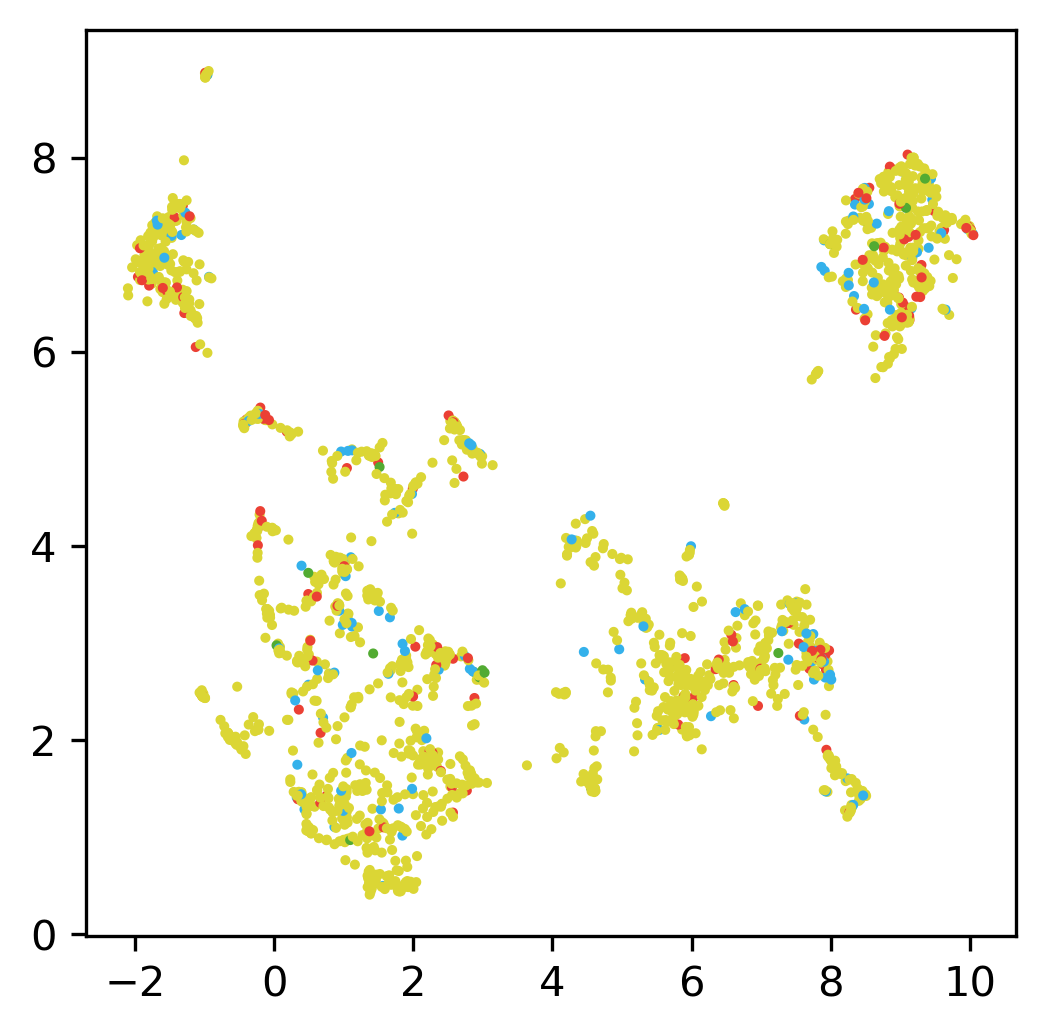

In [40]:
# create a plot of the word vectors
# reduce to two dimensions
reducer = umap.UMAP(metric='cosine', n_components=2, n_neighbors=15, min_dist=0.00, random_state=0)

# create word vectors for all words in uni_tweet_words
X = np.empty([2, 2])
X = [np.append(X, ft.get_word_vector(word)) for word in uni_tweet_words]
X = np.asarray(X)

# transform to two dimensions
embedding = reducer.fit_transform(X[:,:])

# plot projected word vectors
plt.figure(figsize=(4,4), dpi=300)

# scatterplot of projected word vectors
colors = {"INSULT": '#eb4034',
          "OTHER": "#dbd635",
          "ABUSE": '#34b1eb',
          "PROFANITY": "#52ab32"}

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = [colors.get(cat, " ") for cat in list(category_dict.values())[:]],
    s = 2
    )

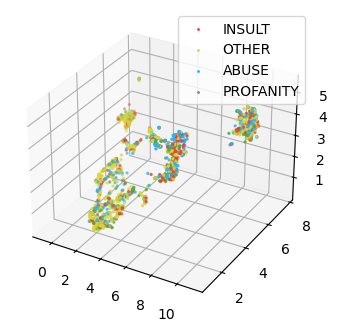

In [41]:
# maybe we should plot this with 3 dimensions 
# Project into 3D space
reducer3D = umap.UMAP(metric='cosine', n_components=3, n_neighbors=15, min_dist=0.00, random_state=0)
embedding3D = reducer3D.fit_transform(X[:,:])


# plot in 3D and create animation (rotate space)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    embedding3D[:, 0],
    embedding3D[:, 1],
    embedding3D[:, 2],
    c = [colors.get(cat, " ") for cat in list(category_dict_per.values())[:]],
    s = 2
    )
for color in ['#eb4034',"#dbd635",'#34b1eb',"#52ab32"]:
    lbl = list(colors.keys())[list(colors.values()).index(color)]
    plt.scatter([],[], [], color=color, label=lbl)
plt.legend()

def rotate(angle):
    ax.view_init(azim=angle)

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362,10), repeat=True)

## Classify new tweets

In [42]:
# calculate center of mass vector for list of words (used here for article as
# collection of words)
def get_com_vector(words : list) -> np.array:
    # list of words in the word2vec model
    words = [word for word in words if word in uni_tweet_words]
    # get the vectors
    vectors = np.array([ft.get_word_vector(word) for word in words])
    # return the sum of all vectors devided by the amount of words from words in the model
    vector = np.sum(vectors, axis=0)
    return vector / len(words)

# get vector for each tweet
tweet_vectors = []
for tweet in tweet_words:
    vec = get_com_vector(tweet)
    tweet_vectors.append(vec)


In [44]:
# function to preprocess and transform new tweets
def new_tweet_vector(tweet : str):
    prep_new = process_tweets(tweet)
    doc_new = nlp(prep_new)

    words_new = [
                    word.lemma_ for word in doc_new
                    if (not word.is_stop) and (len(word)>2)
                 ]

    # calculate vector for new article
    new_tweet_v = get_com_vector(words_new)

    return new_tweet_v, words_new

In [45]:
# create tweet vectors of test tweets
new_tweet_v = []
words_new = []
for tweet in data_test.tweets_clean:
    new_tweet_v.append(new_tweet_vector(tweet)[0])
    words_new.append(new_tweet_vector(tweet)[1])

/var/folders/gz/m10sqzrs1zv7071q82xq75fh0000gn/T/ipykernel_31988/2706328258.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return vector / len(words)


In [47]:
# Remove tweets where there are no words in the word2vec model  
tweet_words_dict = remove_nan_tweets(words_new, uni_tweet_words)   

# subset data_test and tweet_words, only tweets where at least one word is in the word2vec model
data_test = data_test.iloc[list(tweet_words_dict.keys()), :]
data_test = data_test.reset_index()
new_tweet_v = [new_tweet_v[i] for i in list(tweet_words_dict.keys())]

In [48]:
# Encode the classes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(data_pre["granulareKlassifikation"])
encoder.classes_

array(['ABUSE', 'INSULT', 'OTHER', 'PROFANITY'], dtype=object)

In [49]:
# Train a Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(tweet_vectors, y_transformed)
rfc_predictions = rfc.predict(new_tweet_v)
# rfc_human_readeable = encoder.inverse_transform(rfc_predictions)

In [50]:
# transform predictions to classes
encoder_dict = dict(enumerate(encoder.classes_.flatten(), 0))
rfc_predictions = [encoder_dict[x] for x in rfc_predictions]

In [53]:
# evaluate predictions
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == data_test["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(rfc_predictions)        

In [54]:
accuracy

0.7338820301783264

In [58]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(data_test["granulareKlassifikation"], rfc_predictions))

              precision    recall  f1-score   support

       ABUSE       0.97      0.34      0.50        85
      INSULT       0.93      0.31      0.47       167
       OTHER       0.70      0.99      0.82       451
   PROFANITY       1.00      0.27      0.42        26

    accuracy                           0.73       729
   macro avg       0.90      0.48      0.55       729
weighted avg       0.80      0.73      0.69       729



In [56]:
rfc_predictions[:10]

['ABUSE',
 'OTHER',
 'INSULT',
 'INSULT',
 'OTHER',
 'OTHER',
 'INSULT',
 'OTHER',
 'OTHER',
 'OTHER']

In [57]:
data_test["granulareKlassifikation"][:10]

0     ABUSE
1    INSULT
2    INSULT
3    INSULT
4    INSULT
5    INSULT
6    INSULT
7     OTHER
8     OTHER
9     OTHER
Name: granulareKlassifikation, dtype: object

In [ ]:
# value counts of predictions
[cat_predictions.count(x) for x in ['ABUSE', 'PROFANITY','INSULT', 'OTHER']]

In [ ]:
data_test["granulareKlassifikation"].value_counts()

In [ ]:
data_test.head(10)